In [49]:
import keras
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import tensorflow
from tensorflow.python.client import device_lib
import time
#print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tensorflow.test.is_gpu_available()


True

## Load from keras.datasets.cifar10

In [50]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

## Preprocessing

In [51]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('test:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
test: (10000, 3072) (10000, 10)


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [52]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}, drop = drop_list):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

## HyperParameters

In [53]:
EPOCHS = 100
BATCH_SIZE_LIST = [50]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)#, momentum=MOMENTUM)

## Training (Add EarlyStop callback)

In [54]:
callback=1
def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1], CALLBACKS= callback):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, 
              epochs=e, batch_size=bs, shuffle=True, callbacks=CALLBACKS) #add callback "early stop"
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record

## EarlyStop (monitor val_loss)

In [55]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
CALLBACKS = [early_stop]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 164us/step - loss: 1.9902 - acc: 0.3144 - val_loss: 1.6628 - val_acc: 0.4188
Epoch 2/100
50000/50000 [==============================] - 7s 144us/step - loss: 1.7317 - acc: 0.3863 - val_loss: 1.6359 - val_acc: 0.4216
Epoch 3/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.6749 - acc: 0.4062 - val_loss: 1.6063 - val_acc: 0.4261
Epoch 4/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.6406 - acc: 0.4210 - val_loss: 1.5505 - val_acc: 0.4508
Epoch 5/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.6185 - acc: 0.4266 - val_loss: 1.5442 - val_acc: 0.4616
Epoch 6/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.5994 - acc: 0.4344 - val_loss: 1.4949 - val_acc: 0.4764
Epoch 7/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.5838 - acc: 0.4402 - val_loss: 1.

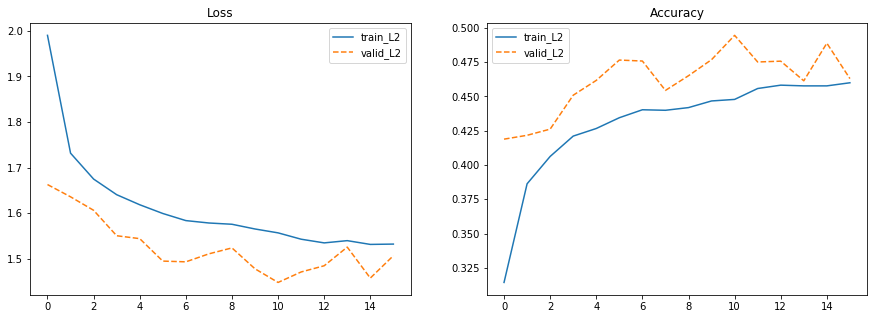

In [56]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()

## EarlyStop (monitor val_acc patience=10)

In [57]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1)
CALLBACKS = [early_stop]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 166us/step - loss: 1.9950 - acc: 0.3145 - val_loss: 1.6522 - val_acc: 0.4193
Epoch 2/100
50000/50000 [==============================] - 7s 149us/step - loss: 1.7344 - acc: 0.3831 - val_loss: 1.6056 - val_acc: 0.4250
Epoch 3/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.6689 - acc: 0.4070 - val_loss: 1.6010 - val_acc: 0.4351
Epoch 4/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.6347 - acc: 0.4193 - val_loss: 1.6129 - val_acc: 0.4268
Epoch 5/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.6169 - acc: 0.4257 - val_loss: 1.5090 - val_acc: 0.4715
Epoch 6/100
50000/50000 [==============================] - 7s 144us/step - loss: 1.6065 - acc: 0.4280 - val_loss: 1.5213 - val_acc: 0.4701
Epoch 7/100
50000/50000 [==============================] - 7s 144us/step - loss: 1.5873 - acc: 0.4393 - val_loss: 1.

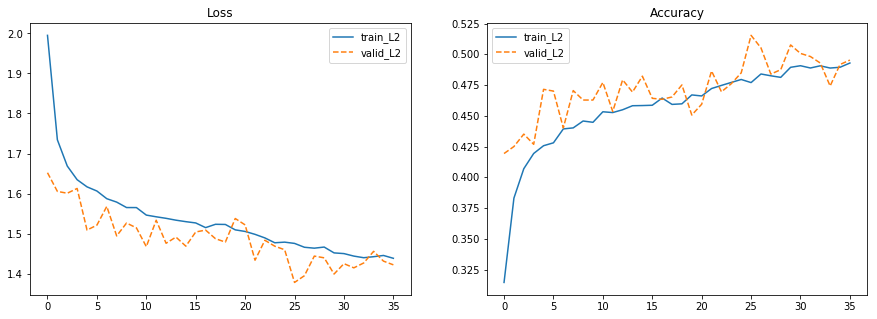

In [58]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()

## EarlyStop (monitor val_acc patience=25)

In [59]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=25, verbose=1)
CALLBACKS = [early_stop]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 163us/step - loss: 2.0029 - acc: 0.3136 - val_loss: 1.6954 - val_acc: 0.3998
Epoch 2/100
50000/50000 [==============================] - 7s 146us/step - loss: 1.7349 - acc: 0.3834 - val_loss: 1.6077 - val_acc: 0.4291
Epoch 3/100
50000/50000 [==============================] - 7s 144us/step - loss: 1.6703 - acc: 0.4082 - val_loss: 1.5781 - val_acc: 0.4383
Epoch 4/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.6432 - acc: 0.4165 - val_loss: 1.5434 - val_acc: 0.4532
Epoch 5/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.6249 - acc: 0.4228 - val_loss: 1.5215 - val_acc: 0.4650
Epoch 6/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.6061 - acc: 0.4304 - val_loss: 1.5146 - val_acc: 0.4596
Epoch 7/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.5993 - acc: 0.4307 - val_loss: 1.

50000/50000 [==============================] - 7s 143us/step - loss: 1.3737 - acc: 0.5162 - val_loss: 1.3657 - val_acc: 0.5143
Epoch 60/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.3743 - acc: 0.5160 - val_loss: 1.3732 - val_acc: 0.5143
Epoch 61/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.3706 - acc: 0.5168 - val_loss: 1.3566 - val_acc: 0.5193
Epoch 62/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.3687 - acc: 0.5176 - val_loss: 1.4619 - val_acc: 0.4880
Epoch 63/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.3749 - acc: 0.5158 - val_loss: 1.3714 - val_acc: 0.5143
Epoch 64/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.3662 - acc: 0.5192 - val_loss: 1.3259 - val_acc: 0.5329
Epoch 65/100
50000/50000 [==============================] - 7s 142us/step - loss: 1.3669 - acc: 0.5192 - val_loss: 1.3376 - val_acc: 0.5207
Epoch 66/100
50000/50000 [=======

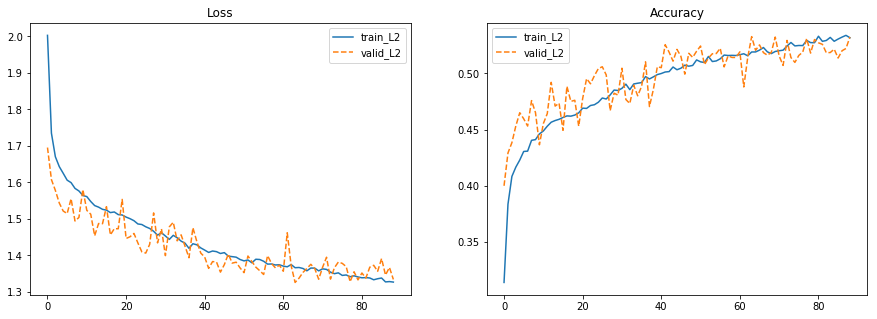

In [60]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()